<a href="https://colab.research.google.com/github/lorenzrossi/AMD-ComicsFaces/blob/main/Complete_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2
import zipfile

#from google.colab import drive
#drive.mount('/content/drive')

from google.colab import files

uploaded = files.upload()

# UPLOAD YOUR KAGGLE API KEY

for fn in uploaded.keys():
  print('key "{name}"'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

#dir = '/content/drive/MyDrive/ComicsFaces'

#X = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/X.pickle','rb'))
#y = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/y.pickle','rb'))


Saving kaggle.json to kaggle.json
key "kaggle.json"


In [41]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [42]:
# usare il link di kaggle per scaricare le immagini

!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2

comic-faces-paired-synthetic-v2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
with zipfile.ZipFile('comic-faces-paired-synthetic-v2.zip','r') as zipref:
     zipref.extractall()
!rm -rf /content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

In [44]:
dir = "/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela"


# I define some parameters in order resize image in an uniform way and I set 3 as number of channels of the image, since I want RGB images
img_width = 100
img_height = 100
img_size = (img_width, img_height)

# Pets is the list in which alle the images will be stored
pics = []

# I define the two categories of pics ( related to the sub-directories of comics and faces)
categories = ['comics','faces']

# I create a funciotn in order to load the data, transform the into array, assign them to a class and store them in the pics list
def create_data():

# the function iterates throught the two sub-directories
    for category in categories:
        path = os.path.join(dir, category)

# assign 0 to comics and 1 to faces, according to the index of the categories
        pic_class = categories.index(category)

# the function then iterates through each image in both the folders. I used the opencv (cv2 when imported) package to read and load them. IMREAD_COLOR keeps the color in the image, whereas IMREAD_GRAYSCALE would turn them into grayscale images.
# The function resize the images as defined by the previous parameters and finally appends the array of the image, together with the class value (creating a sub-list of two values for each image), to the pets list.
# The function skips those images which seem broken.
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, img_size)
                pics.append([new_array, pic_class])
            except Exception as e:
                pass

create_data()

print(len(pics))

# since the previous function iterates linearly through the two sub-directories, I shuffle the data in order to mix shuffle the order of the images
random.shuffle(pics)

for sample in pics[:9]:
    print(sample[1])

20000
0
0
0
0
0
1
0
0
0


In [45]:
# split the data arrays and the labels for the classification task

X = []
y = []

for image, label in pics:
    X.append(image)
    y.append(label)

X = np.array(X).reshape(-1, img_width, img_height, 1)

In [46]:
# Now import all the packages for NN, hyperparameters and data processing 

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tfk = tf.keras
tf.keras.backend.set_floatx("float64")

from sklearn.model_selection import train_test_split

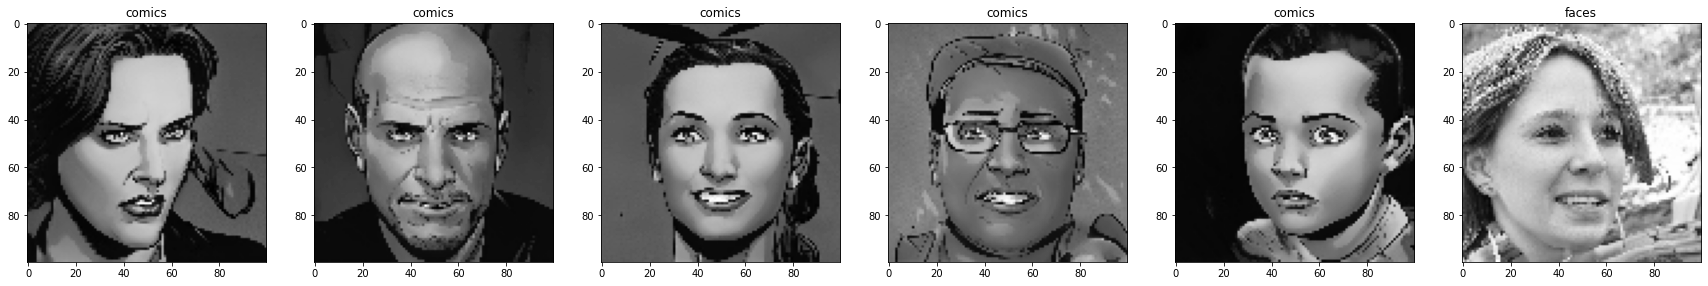

In [47]:
pics_classes = ['comics','faces']

images_to_plot = 6
     

f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

gray_channel = 0

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pics_classes[numeric_label])

In [48]:
number_of_classes = len(pics_classes)    

x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

# one hot encoding
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])
     

# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [49]:
# Hyperparameters
epoch = 20 # n of epochs
batch = 64 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy()

# Defining the optimizer(s)
op_1 = Adam()
#op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/25)

In [50]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','test'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# BASE ARCHITECTURE

## Model 1

In [51]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_37 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 80000)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               10240000  
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                     

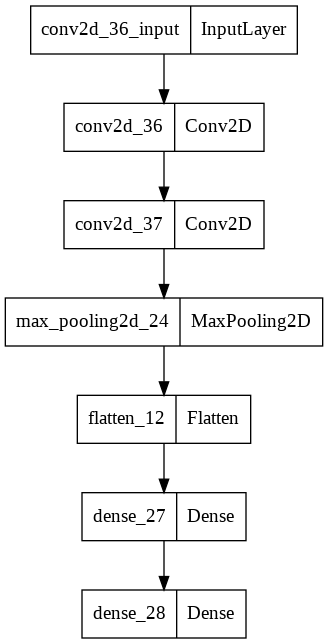

In [52]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/20
200/200 [==============================] - 5s 21ms/step - loss: 0.1026 - binary_accuracy: 0.9751 - val_loss: 0.0070 - val_binary_accuracy: 0.9975
Epoch 2/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0027 - binary_accuracy: 0.9993 - val_loss: 0.0031 - val_binary_accuracy: 0.9991
Epoch 3/20
200/200 [==============================] - 4s 20ms/step - loss: 2.9630e-04 - binary_accuracy: 1.0000 - val_loss: 0.0059 - val_binary_accuracy: 0.9984
Epoch 4/20
200/200 [==============================] - 4s 20ms/step - loss: 6.3472e-05 - binary_accuracy: 1.0000 - val_loss: 0.0044 - val_binary_accuracy: 0.9988
Epoch 5/20
200/200 [==============================] - 4s 20ms/step - loss: 2.8999e-05 - binary_accuracy: 1.0000 - val_loss: 0.0056 - val_binary_accuracy: 0.9988
Epoch 6/20
200/200 [==============================] - 4s 20ms/step - loss: 2.0235e-05 - binary_accuracy: 1.0000 - val_loss: 0.0050 - val_binary_accuracy: 0.9988
Epoch 7/20
200/200 [======================

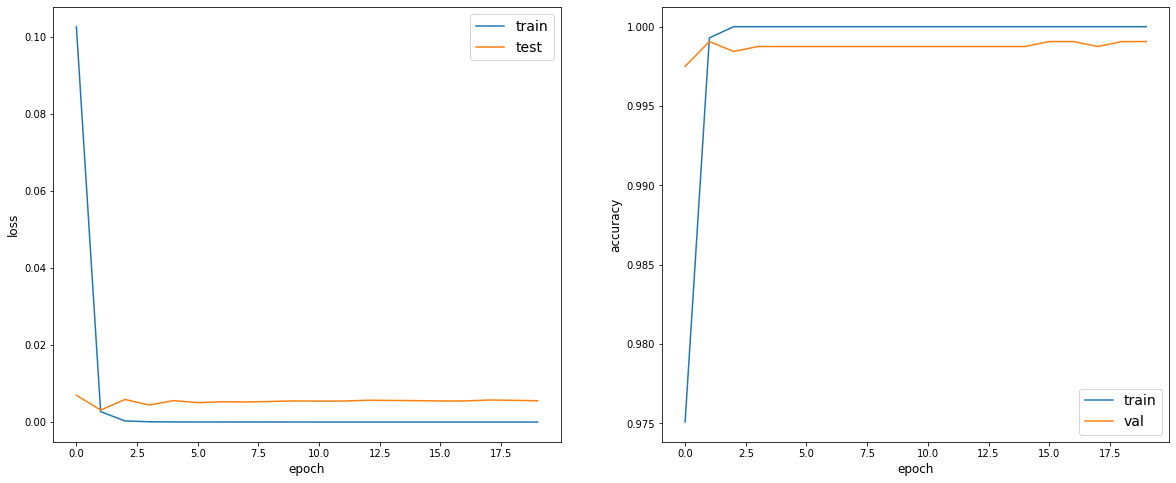

125/125 [==============================] - 1s 6ms/step - loss: 0.0075 - binary_accuracy: 0.9982
test loss, test acc: [0.0075244059514032536, 0.99825]


In [53]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [54]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_39 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 40000)           

Epoch 1/20
200/200 [==============================] - 5s 25ms/step - loss: 0.1114 - binary_accuracy: 0.9669 - val_loss: 0.0073 - val_binary_accuracy: 0.9978
Epoch 2/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0046 - binary_accuracy: 0.9984 - val_loss: 0.0053 - val_binary_accuracy: 0.9981
Epoch 3/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0037 - binary_accuracy: 0.9984 - val_loss: 0.0039 - val_binary_accuracy: 0.9984
Epoch 4/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0011 - binary_accuracy: 0.9996 - val_loss: 0.0041 - val_binary_accuracy: 0.9981
Epoch 5/20
200/200 [==============================] - 5s 24ms/step - loss: 2.1760e-04 - binary_accuracy: 1.0000 - val_loss: 0.0048 - val_binary_accuracy: 0.9981
Epoch 6/20
200/200 [==============================] - 5s 24ms/step - loss: 1.2806e-04 - binary_accuracy: 1.0000 - val_loss: 0.0040 - val_binary_accuracy: 0.9981
Epoch 7/20
200/200 [==============================

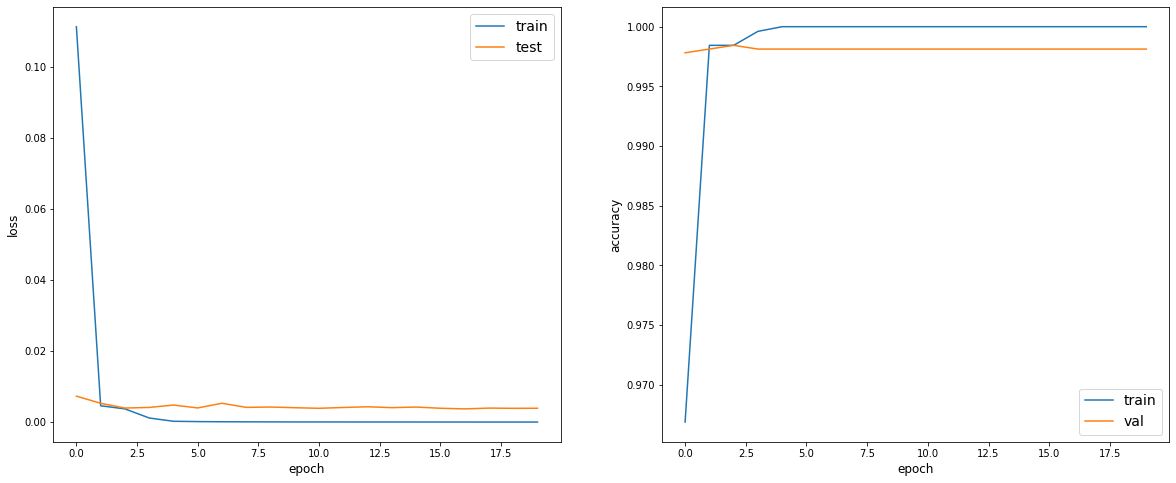

125/125 [==============================] - 1s 7ms/step - loss: 0.0085 - binary_accuracy: 0.9988
test loss, test acc: [0.008454118142653864, 0.99875]


In [55]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

# Model 3

In [56]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_42 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 25, 25, 128)     

Epoch 1/20
200/200 [==============================] - 6s 28ms/step - loss: 0.1157 - binary_accuracy: 0.9608 - val_loss: 0.0064 - val_binary_accuracy: 0.9975
Epoch 2/20
200/200 [==============================] - 5s 27ms/step - loss: 0.0060 - binary_accuracy: 0.9982 - val_loss: 0.0114 - val_binary_accuracy: 0.9966
Epoch 3/20
200/200 [==============================] - 5s 27ms/step - loss: 0.0035 - binary_accuracy: 0.9991 - val_loss: 0.0060 - val_binary_accuracy: 0.9975
Epoch 4/20
200/200 [==============================] - 5s 27ms/step - loss: 0.0012 - binary_accuracy: 0.9995 - val_loss: 0.0055 - val_binary_accuracy: 0.9978
Epoch 5/20
200/200 [==============================] - 5s 27ms/step - loss: 2.4924e-04 - binary_accuracy: 0.9999 - val_loss: 0.0047 - val_binary_accuracy: 0.9984
Epoch 6/20
200/200 [==============================] - 5s 27ms/step - loss: 1.2666e-04 - binary_accuracy: 1.0000 - val_loss: 0.0125 - val_binary_accuracy: 0.9962
Epoch 7/20
200/200 [==============================

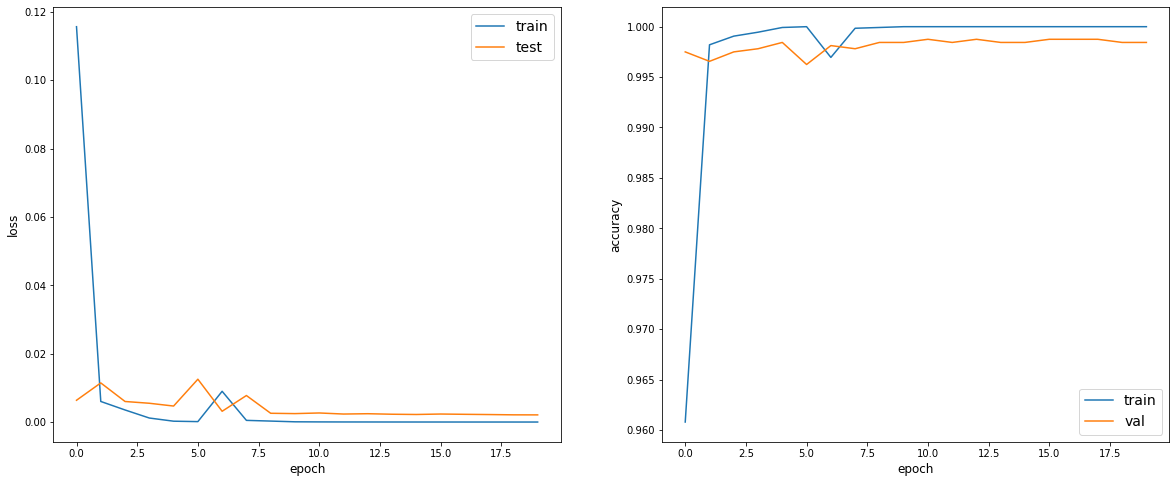

125/125 [==============================] - 1s 7ms/step - loss: 0.0083 - binary_accuracy: 0.9982
test loss, test acc: [0.008325062625132112, 0.99825]


In [57]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# ADDING DROPOUT LAYERS

# Model 1

In [58]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_46 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 50, 50, 32)        0         
                                                                 
 flatten_15 (Flatten)        (None, 80000)             0         
                                                                 
 dense_33 (Dense)            (None, 128)               10240000  
                                                     

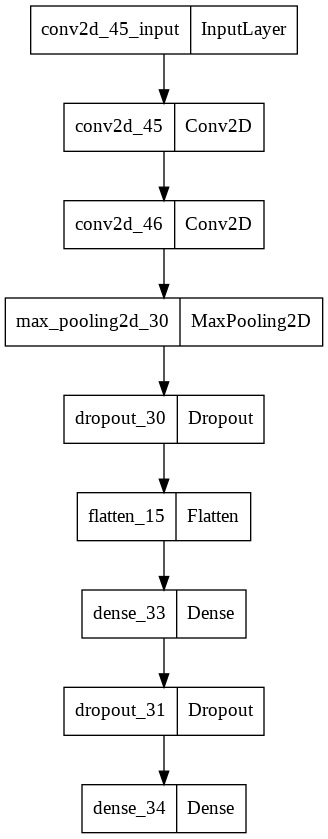

In [59]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/20
200/200 [==============================] - 5s 21ms/step - loss: 0.1582 - binary_accuracy: 0.9729 - val_loss: 0.0068 - val_binary_accuracy: 0.9975
Epoch 2/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0031 - binary_accuracy: 0.9987 - val_loss: 0.0047 - val_binary_accuracy: 0.9984
Epoch 3/20
200/200 [==============================] - 4s 20ms/step - loss: 6.3507e-04 - binary_accuracy: 0.9998 - val_loss: 0.0062 - val_binary_accuracy: 0.9981
Epoch 4/20
200/200 [==============================] - 4s 20ms/step - loss: 8.7005e-04 - binary_accuracy: 0.9998 - val_loss: 0.0043 - val_binary_accuracy: 0.9984
Epoch 5/20
200/200 [==============================] - 4s 20ms/step - loss: 3.0501e-04 - binary_accuracy: 0.9999 - val_loss: 0.0040 - val_binary_accuracy: 0.9981
Epoch 6/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0010 - binary_accuracy: 0.9997 - val_loss: 0.0043 - val_binary_accuracy: 0.9991
Epoch 7/20
200/200 [==========================

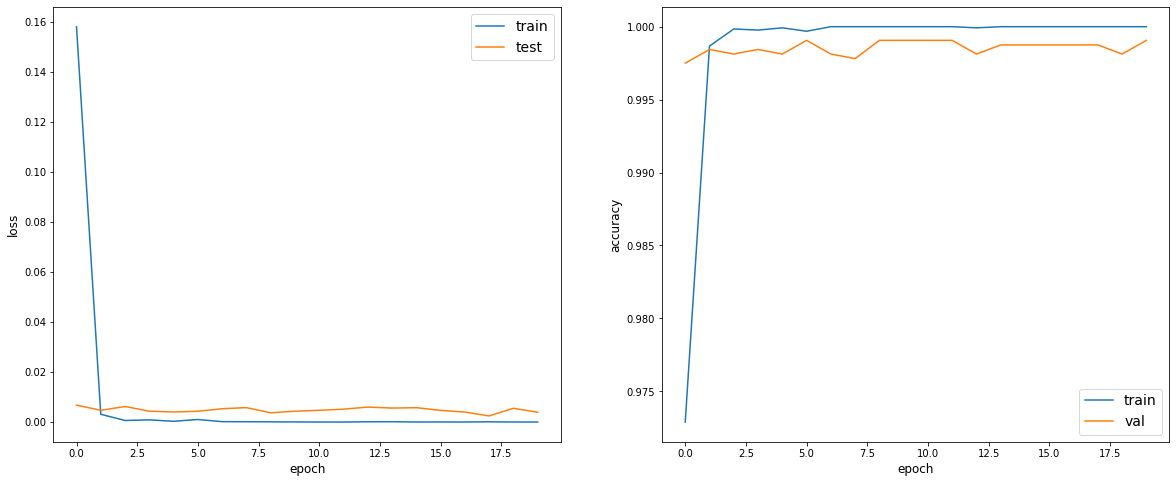

125/125 [==============================] - 1s 6ms/step - loss: 0.0121 - binary_accuracy: 0.9985
test loss, test acc: [0.012065951689607736, 0.9985]


In [60]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [61]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_48 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 50, 50, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                

Epoch 1/20
200/200 [==============================] - 6s 25ms/step - loss: 0.1364 - binary_accuracy: 0.9539 - val_loss: 0.0073 - val_binary_accuracy: 0.9975
Epoch 2/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0106 - binary_accuracy: 0.9968 - val_loss: 0.0747 - val_binary_accuracy: 0.9756
Epoch 3/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0095 - binary_accuracy: 0.9966 - val_loss: 0.0039 - val_binary_accuracy: 0.9988
Epoch 4/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0052 - binary_accuracy: 0.9984 - val_loss: 0.0036 - val_binary_accuracy: 0.9988
Epoch 5/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0014 - binary_accuracy: 0.9997 - val_loss: 0.0053 - val_binary_accuracy: 0.9984
Epoch 6/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0020 - binary_accuracy: 0.9994 - val_loss: 0.0030 - val_binary_accuracy: 0.9988
Epoch 7/20
200/200 [==============================] - 5s 2

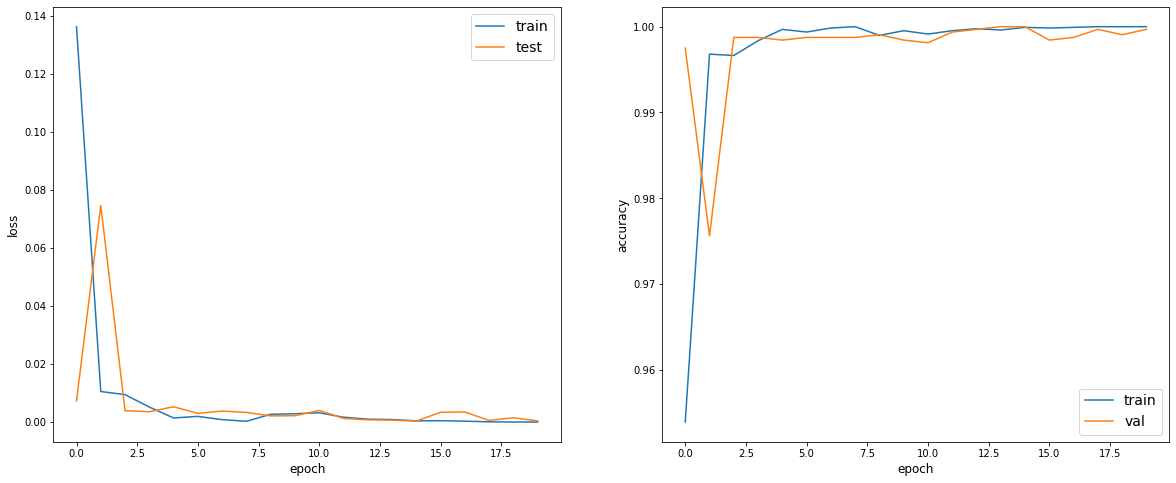

125/125 [==============================] - 1s 7ms/step - loss: 0.0063 - binary_accuracy: 0.9990
test loss, test acc: [0.006338541200459392, 0.999]


In [62]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

## Model 3

In [63]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_51 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 50, 50, 32)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                

Epoch 1/20
200/200 [==============================] - 6s 29ms/step - loss: 0.1182 - binary_accuracy: 0.9435 - val_loss: 0.0111 - val_binary_accuracy: 0.9966
Epoch 2/20
200/200 [==============================] - 6s 28ms/step - loss: 0.0115 - binary_accuracy: 0.9963 - val_loss: 0.0061 - val_binary_accuracy: 0.9981
Epoch 3/20
200/200 [==============================] - 6s 28ms/step - loss: 0.0074 - binary_accuracy: 0.9975 - val_loss: 0.0050 - val_binary_accuracy: 0.9988
Epoch 4/20
200/200 [==============================] - 6s 28ms/step - loss: 0.0044 - binary_accuracy: 0.9987 - val_loss: 0.0019 - val_binary_accuracy: 0.9994
Epoch 5/20
200/200 [==============================] - 6s 28ms/step - loss: 0.0033 - binary_accuracy: 0.9988 - val_loss: 0.0156 - val_binary_accuracy: 0.9959
Epoch 6/20
200/200 [==============================] - 6s 28ms/step - loss: 0.0027 - binary_accuracy: 0.9991 - val_loss: 0.0027 - val_binary_accuracy: 0.9991
Epoch 7/20
200/200 [==============================] - 6s 2

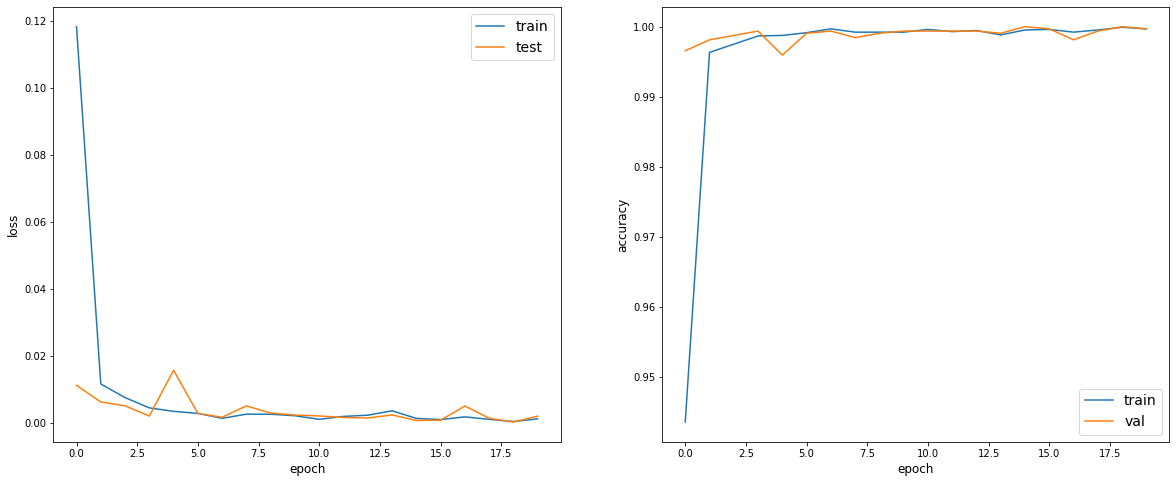

125/125 [==============================] - 1s 7ms/step - loss: 0.0033 - binary_accuracy: 0.9995
test loss, test acc: [0.0032670242642948077, 0.9995]


In [64]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# ADDING BATCH NORMALIZATION LAYERS

## Model 1

In [65]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_27 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_55 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_28 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

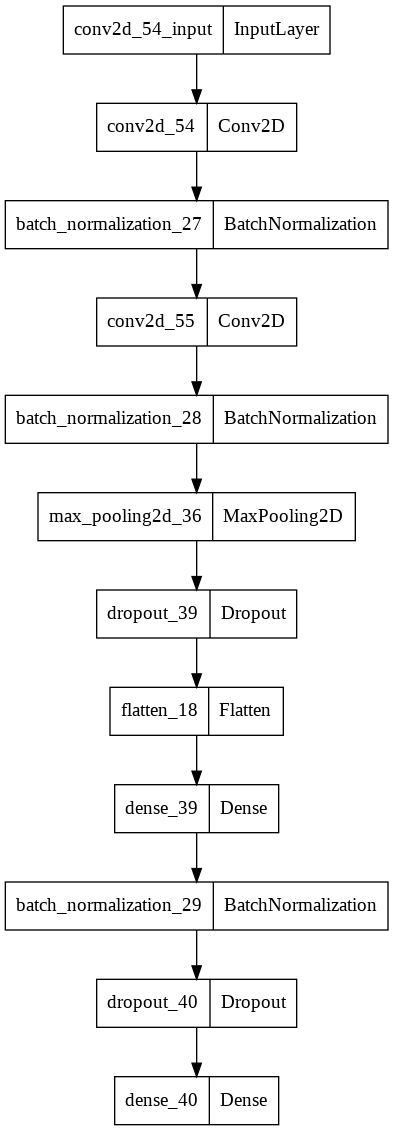

In [66]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/20
200/200 [==============================] - 8s 34ms/step - loss: 0.0331 - binary_accuracy: 0.9897 - val_loss: 0.2156 - val_binary_accuracy: 0.9350
Epoch 2/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0043 - binary_accuracy: 0.9984 - val_loss: 0.6727 - val_binary_accuracy: 0.5784
Epoch 3/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0021 - binary_accuracy: 0.9994 - val_loss: 0.0036 - val_binary_accuracy: 0.9997
Epoch 4/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 9.5951e-04 - val_binary_accuracy: 1.0000
Epoch 5/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 0.0355 - val_binary_accuracy: 0.9884
Epoch 6/20
200/200 [==============================] - 7s 33ms/step - loss: 4.2822e-04 - binary_accuracy: 1.0000 - val_loss: 3.6263e-04 - val_binary_accuracy: 1.0000
Epoch 7/20
200/200 [==========================

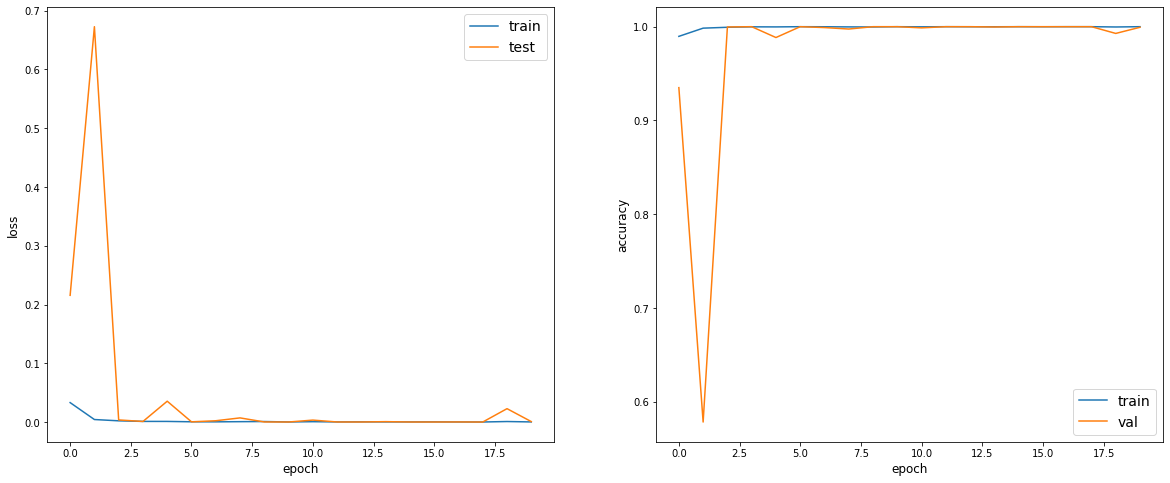

125/125 [==============================] - 1s 7ms/step - loss: 1.4967e-04 - binary_accuracy: 1.0000
test loss, test acc: [0.00014966757040001493, 1.0]


In [67]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [68]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_30 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_57 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_31 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

Epoch 1/20
200/200 [==============================] - 9s 41ms/step - loss: 0.0189 - binary_accuracy: 0.9939 - val_loss: 1.1782 - val_binary_accuracy: 0.5472
Epoch 2/20
200/200 [==============================] - 8s 40ms/step - loss: 0.0036 - binary_accuracy: 0.9988 - val_loss: 5.1562 - val_binary_accuracy: 0.8103
Epoch 3/20
200/200 [==============================] - 8s 40ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.7457 - val_binary_accuracy: 0.9522
Epoch 4/20
200/200 [==============================] - 8s 40ms/step - loss: 9.6473e-04 - binary_accuracy: 0.9998 - val_loss: 5.1881e-04 - val_binary_accuracy: 1.0000
Epoch 5/20
200/200 [==============================] - 8s 40ms/step - loss: 0.0023 - binary_accuracy: 0.9995 - val_loss: 0.0224 - val_binary_accuracy: 0.9994
Epoch 6/20
200/200 [==============================] - 8s 40ms/step - loss: 0.0010 - binary_accuracy: 0.9998 - val_loss: 0.2082 - val_binary_accuracy: 0.9944
Epoch 7/20
200/200 [==============================

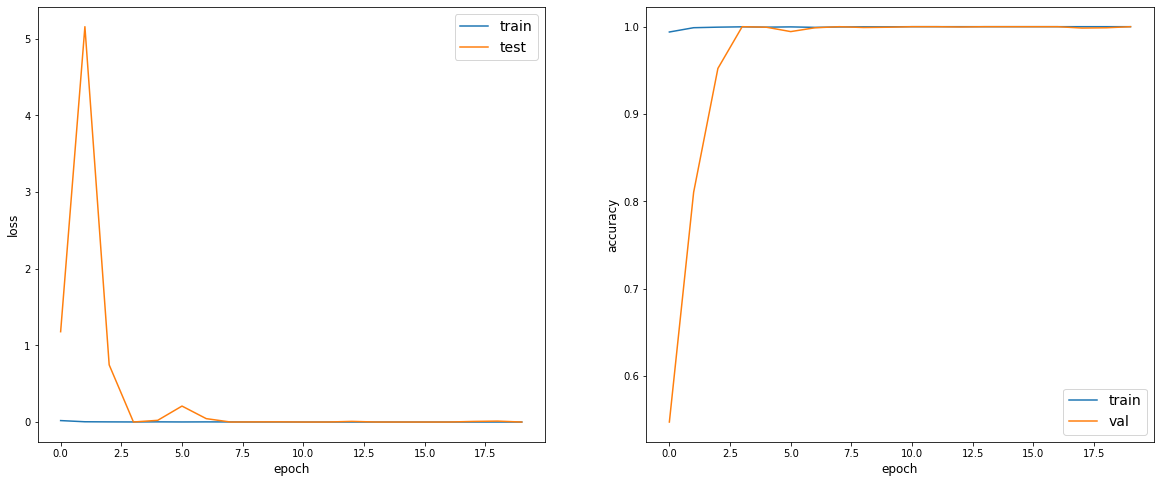

125/125 [==============================] - 1s 8ms/step - loss: 2.5121e-05 - binary_accuracy: 1.0000
test loss, test acc: [2.512120711445162e-05, 1.0]


In [69]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

## Model 3

In [70]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_34 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_60 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_35 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

Epoch 1/20
200/200 [==============================] - 11s 46ms/step - loss: 0.0165 - binary_accuracy: 0.9935 - val_loss: 1.6782 - val_binary_accuracy: 0.6522
Epoch 2/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0055 - binary_accuracy: 0.9984 - val_loss: 1.5943 - val_binary_accuracy: 0.5244
Epoch 3/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0014 - binary_accuracy: 0.9996 - val_loss: 1.1600 - val_binary_accuracy: 0.6166
Epoch 4/20
200/200 [==============================] - 9s 45ms/step - loss: 8.8033e-04 - binary_accuracy: 0.9998 - val_loss: 0.0749 - val_binary_accuracy: 0.9719
Epoch 5/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.0195 - val_binary_accuracy: 0.9988
Epoch 6/20
200/200 [==============================] - 9s 45ms/step - loss: 3.7293e-04 - binary_accuracy: 0.9999 - val_loss: 1.9455e-04 - val_binary_accuracy: 1.0000
Epoch 7/20
200/200 [=========================

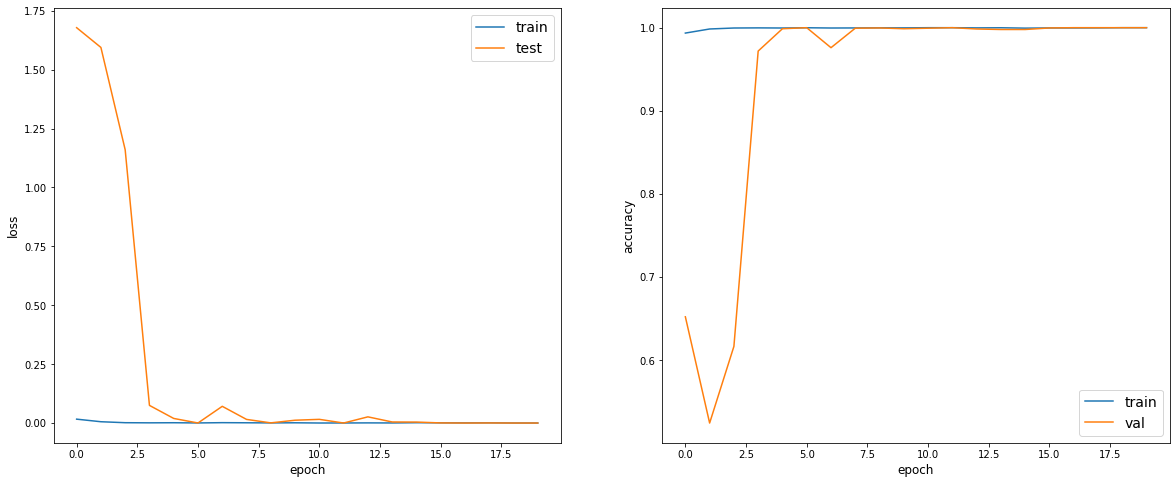

125/125 [==============================] - 1s 8ms/step - loss: 1.1283e-04 - binary_accuracy: 1.0000
test loss, test acc: [0.00011282629873098917, 1.0]


In [71]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# ADDING ADDITIONAL DENSE LAYER

## Model 1

In [72]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(256, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_39 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_64 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_40 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

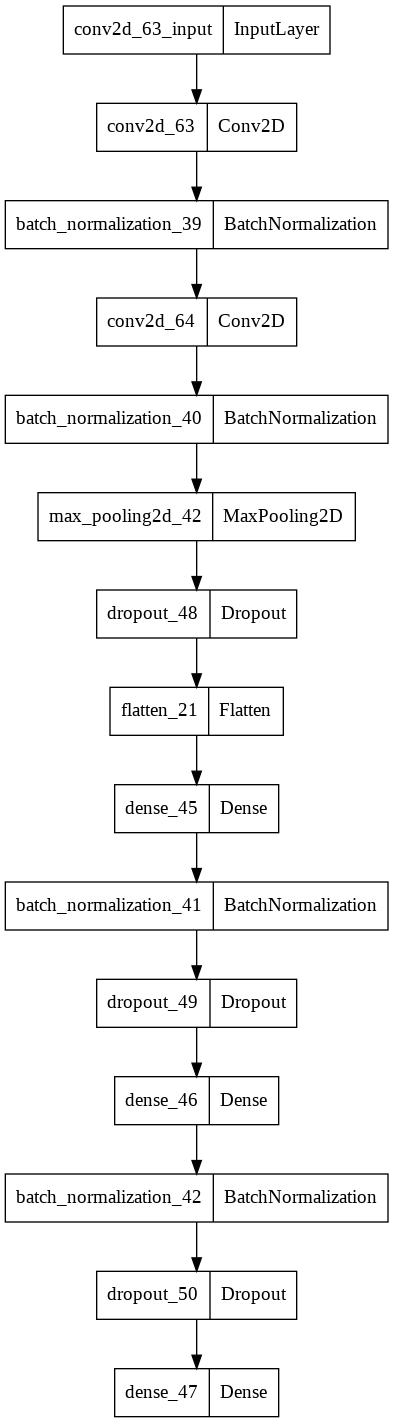

In [73]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/20
200/200 [==============================] - 8s 37ms/step - loss: 0.0236 - binary_accuracy: 0.9912 - val_loss: 3.1241 - val_binary_accuracy: 0.5075
Epoch 2/20
200/200 [==============================] - 7s 34ms/step - loss: 0.0033 - binary_accuracy: 0.9988 - val_loss: 1.3567 - val_binary_accuracy: 0.6372
Epoch 3/20
200/200 [==============================] - 7s 34ms/step - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 0.0256 - val_binary_accuracy: 0.9941
Epoch 4/20
200/200 [==============================] - 7s 34ms/step - loss: 6.9217e-04 - binary_accuracy: 0.9999 - val_loss: 0.0026 - val_binary_accuracy: 0.9994
Epoch 5/20
200/200 [==============================] - 7s 34ms/step - loss: 0.0014 - binary_accuracy: 0.9993 - val_loss: 2.8989e-04 - val_binary_accuracy: 1.0000
Epoch 6/20
200/200 [==============================] - 7s 34ms/step - loss: 6.5907e-04 - binary_accuracy: 0.9998 - val_loss: 2.0270e-04 - val_binary_accuracy: 1.0000
Epoch 7/20
200/200 [======================

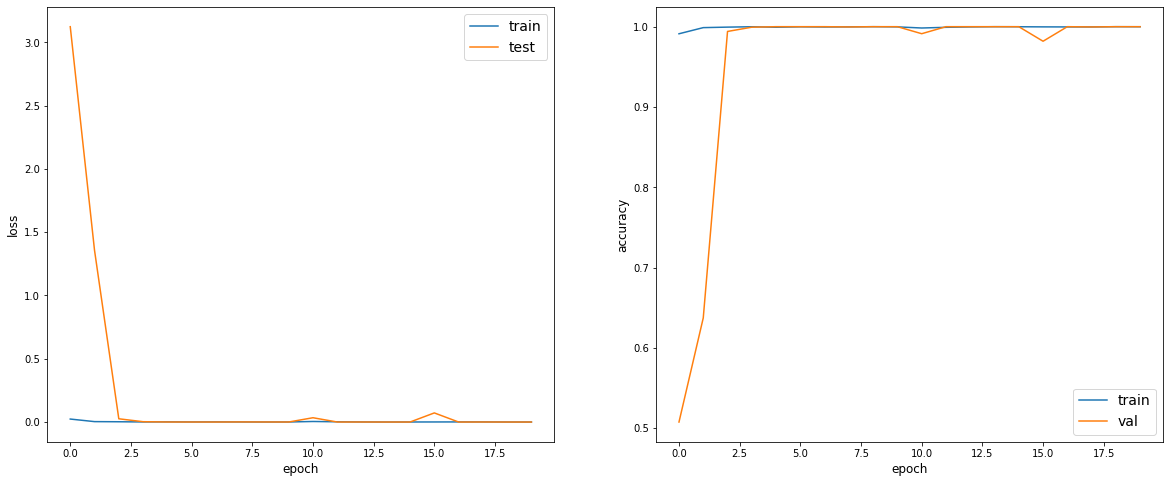

125/125 [==============================] - 1s 7ms/step - loss: 2.6987e-04 - binary_accuracy: 0.9998
test loss, test acc: [0.00026986987444175853, 0.99975]


In [74]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [75]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_43 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_66 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_44 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

Epoch 1/20
200/200 [==============================] - 10s 43ms/step - loss: 0.0213 - binary_accuracy: 0.9921 - val_loss: 5.4201 - val_binary_accuracy: 0.5075
Epoch 2/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0039 - binary_accuracy: 0.9987 - val_loss: 1.8486 - val_binary_accuracy: 0.5650
Epoch 3/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0031 - binary_accuracy: 0.9991 - val_loss: 0.6605 - val_binary_accuracy: 0.8850
Epoch 4/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - val_loss: 0.0161 - val_binary_accuracy: 0.9956
Epoch 5/20
200/200 [==============================] - 8s 41ms/step - loss: 4.0697e-04 - binary_accuracy: 1.0000 - val_loss: 0.0052 - val_binary_accuracy: 0.9991
Epoch 6/20
200/200 [==============================] - 8s 41ms/step - loss: 2.6694e-04 - binary_accuracy: 1.0000 - val_loss: 6.6530e-04 - val_binary_accuracy: 0.9994
Epoch 7/20
200/200 [=========================

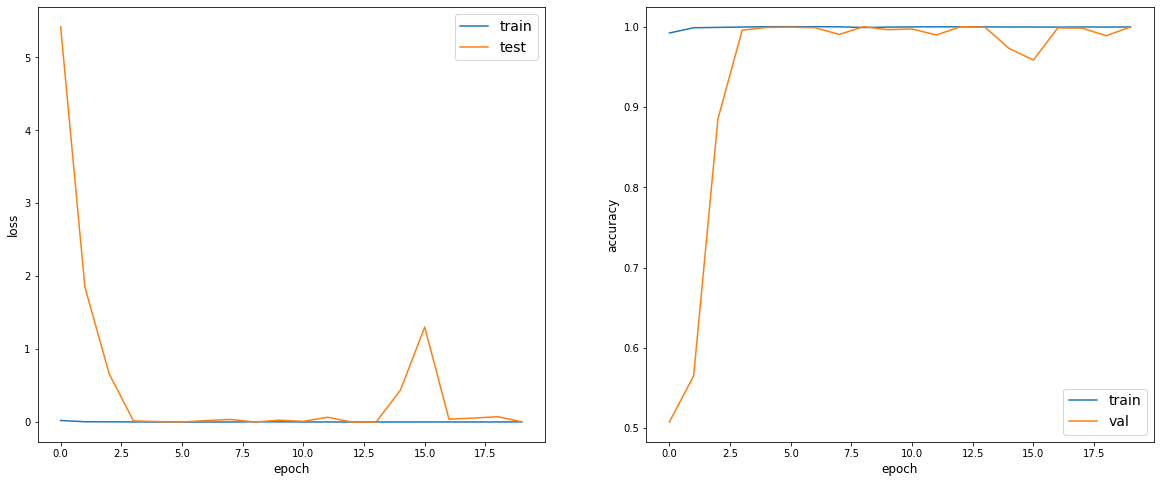

125/125 [==============================] - 1s 8ms/step - loss: 0.0031 - binary_accuracy: 0.9992
test loss, test acc: [0.0030695657796696797, 0.99925]


In [76]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

## Model 3

In [77]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_48 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_69 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_49 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

Epoch 1/20
200/200 [==============================] - 11s 47ms/step - loss: 0.0244 - binary_accuracy: 0.9911 - val_loss: 10.5259 - val_binary_accuracy: 0.5075
Epoch 2/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0070 - binary_accuracy: 0.9978 - val_loss: 4.3789 - val_binary_accuracy: 0.5084
Epoch 3/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0057 - binary_accuracy: 0.9985 - val_loss: 0.0565 - val_binary_accuracy: 0.9800
Epoch 4/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0020 - binary_accuracy: 0.9993 - val_loss: 0.0825 - val_binary_accuracy: 0.9819
Epoch 5/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0024 - binary_accuracy: 0.9994 - val_loss: 0.0018 - val_binary_accuracy: 0.9994
Epoch 6/20
200/200 [==============================] - 9s 45ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - val_loss: 0.0306 - val_binary_accuracy: 0.9928
Epoch 7/20
200/200 [==============================] - 9s

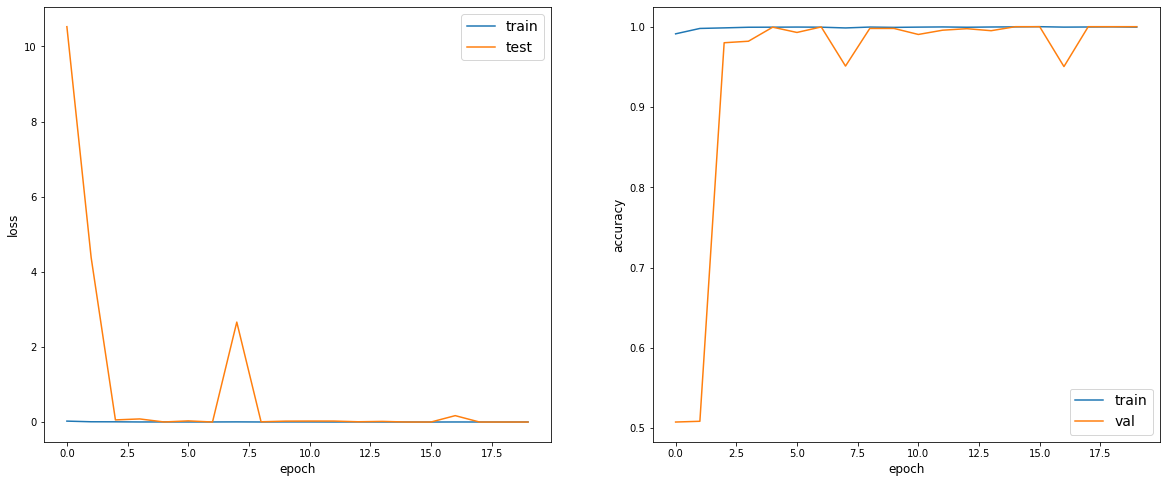

125/125 [==============================] - 1s 8ms/step - loss: 2.2833e-05 - binary_accuracy: 1.0000
test loss, test acc: [2.2833222373416996e-05, 1.0]


In [78]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)